# Full Ising model simulation for branch structure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from utils.gen_utils import create_lattice, graph_to_model_format, autocorr
from IsingModel import IsingModel
from main_tree import simulate_ising_model

from branch_sim import MamSimulation

/Users/nicolasdebie/miniconda3/envs/ising/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
## set the parameters

tmax = 150

J = 1.0
n_equilib_steps = 1_000
n_mcmc_steps = 1_000
n_samples = None
n_sample_interval = 10
step_algorithm = "wolff"
betas = [0.3,0.35,0.4,0.45,0.5,0.6,0.8,0.9,2.0,3.0]
temps = np.arange(0.5, 3.5, 0.5)

In [3]:
## simulate the stucture
mam = MamSimulation(tmax=tmax)
coordinates, evolve, G = mam.simulate()
nodes, neighbors = graph_to_model_format(G)
print(nodes.shape)

Starting simulation...


100%|██████████| 150/150 [00:02<00:00, 52.27it/s]


Branch growth simulation completed in 2.8983209133148193 seconds
(1510,)


## Thermolization

In [4]:
init_types = {
    "random": np.random.choice([-1, 1], size=nodes.size),
    "aligned": np.ones(nodes.size, dtype=np.int8)
}
results = {}
results_mcmc = {}
for temp in temps:
    for init_type, init_spins in init_types.items():
        if init_type == "random":
            init_spins = np.random.choice([-1, 1], size=nodes.size)
        elif init_type == "aligned":
            init_spins = np.ones(nodes.size, dtype=np.int8)
        
        model = IsingModel(
            nodes=init_spins,
            neighbors=neighbors,
            temp = temp,
            J=J,
            n_equilib_steps=n_equilib_steps,
            n_mcmc_steps=n_mcmc_steps,
            n_samples=n_samples,
            n_sample_interval=n_sample_interval,
            step_algorithm=step_algorithm
        )

        model = simulate_ising_model(model)
        results[(temp, init_type)] = (model.energy_equil, model.magn_equil)
        results_mcmc[(temp, init_type)] = (model.energy_all, model.magn_all)
        

SystemError: CPUDispatcher(<function wolff_step at 0x308df5b40>) returned a result with an exception set

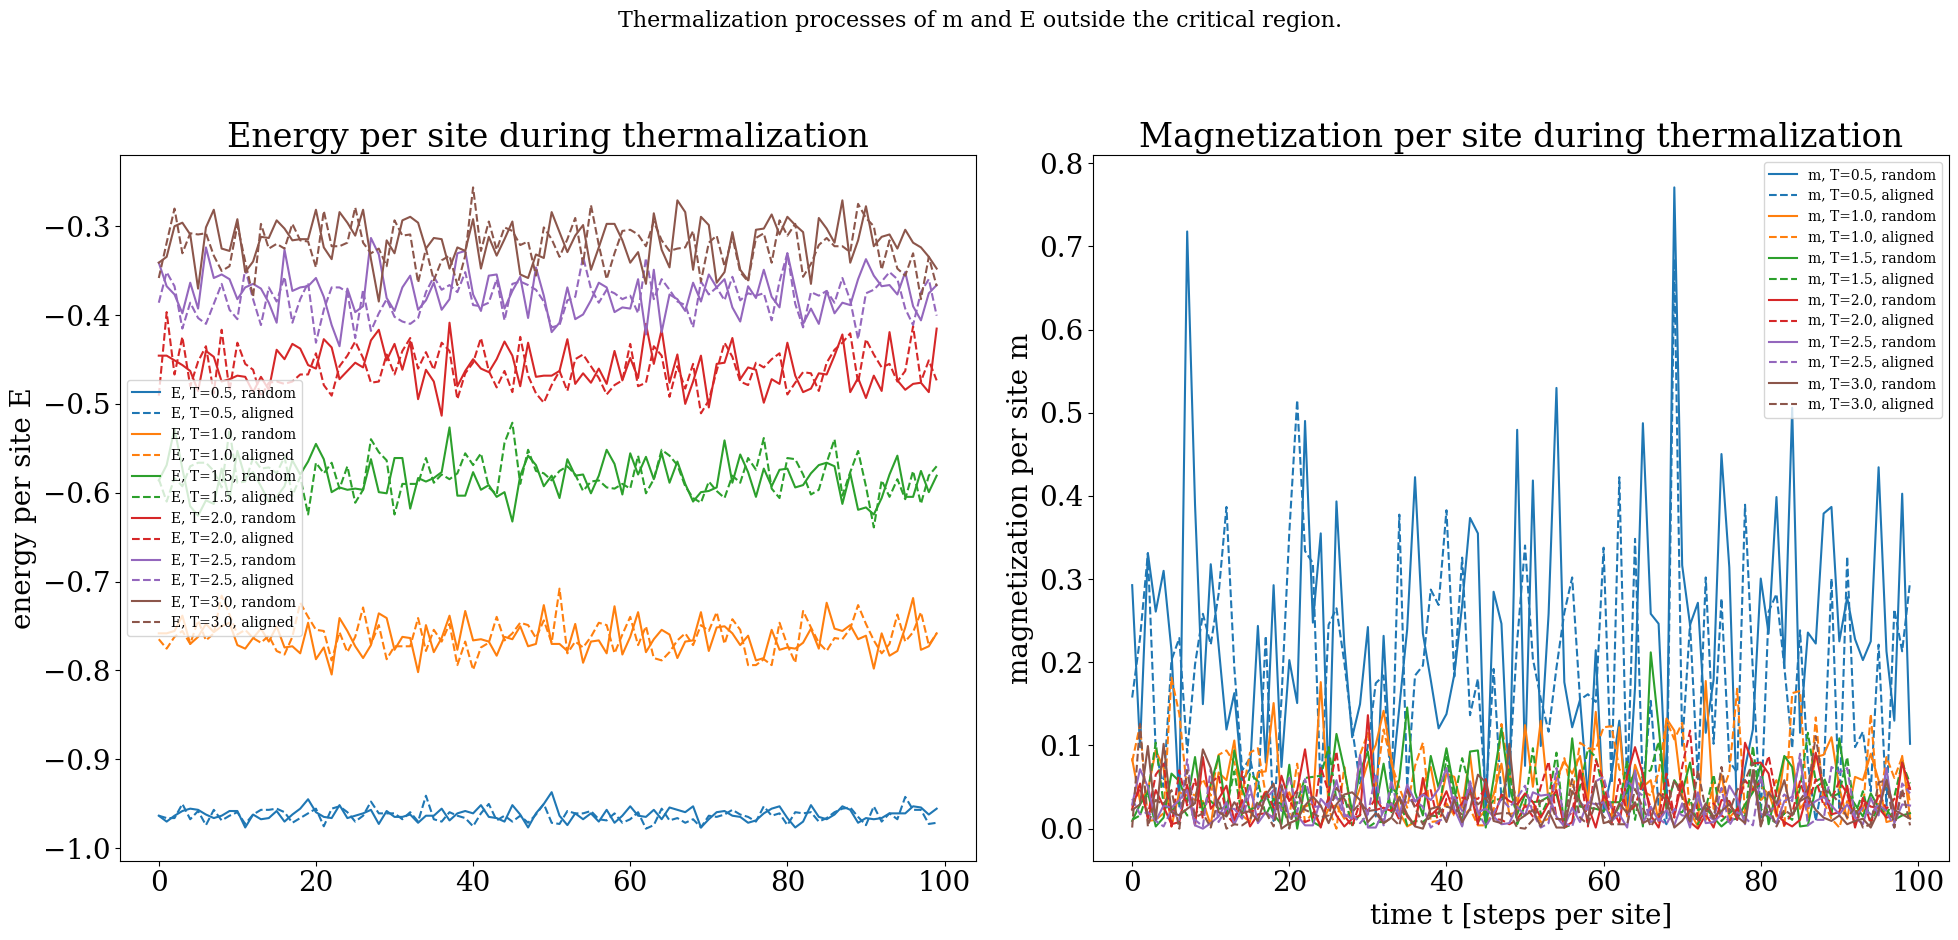

In [6]:
### Plotting the results ###

max_timestep = 100

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
betas = [0.3, 0.4, 0.45]
betas = [0.3,0.5, 0.8]

# Define colors for betas and linestyles for init_types
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
beta_colors = colors[:len(temps)]
init_linestyles = ['-', '--']  # One linestyle per init_type

# First subplot: Energy per site
for idx, temp in enumerate(temps):
    for init_idx, (init_name, _) in enumerate(init_types.items()):
        energy, _ = results[(temp, init_name)]
        axes[0].plot(energy[:max_timestep], 
                     color=beta_colors[idx], 
                     linestyle=init_linestyles[init_idx], 
                     label=f"E, T={temp}, {init_name}")

axes[0].set_ylabel("energy per site E")
axes[0].legend(fontsize=10)
axes[0].set_title("Energy per site during thermalization")

# Second subplot: Magnetization per site
for idx, temp in enumerate(temps):
    for init_idx, (init_name, _) in enumerate(init_types.items()):
        _, magn = results[(temp, init_name)]
        axes[1].plot(magn[:max_timestep], 
                     color=beta_colors[idx], 
                     linestyle=init_linestyles[init_idx], 
                     label=f"m, T={temp}, {init_name}")

axes[1].set_xlabel("time t [steps per site]")
axes[1].set_ylabel("magnetization per site m")
axes[1].legend(fontsize=10)
axes[1].set_title("Magnetization per site during thermalization")

plt.suptitle("Thermalization processes of m and E outside the critical region.", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

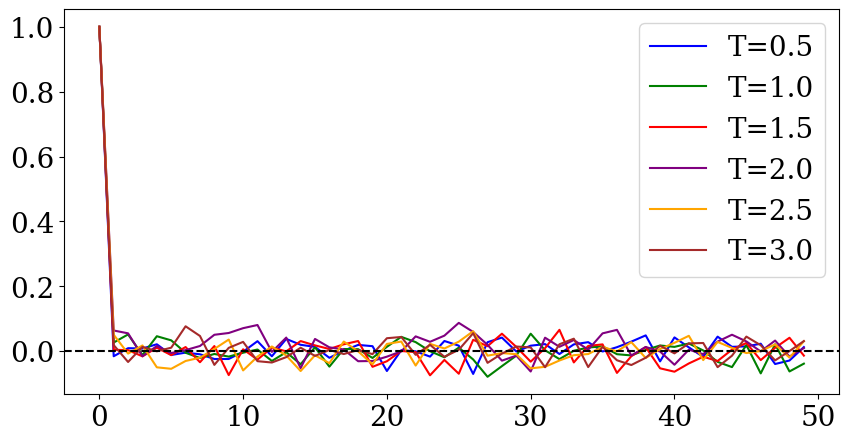

In [7]:
from utils.gen_utils import autocorr
plt.figure(figsize=(10,5))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

betas = [0.3,0.35, 0.4, 0.45,0.5,0.6,0.8]
init_style = "random"
# energy autocorrelation
for i, temp in enumerate(temps):
    corr = autocorr(results_mcmc[(temp, init_style)][0])
    corr = corr[:50]
    plt.plot(corr, color=colors[i], label=f'T={temp}')

# draw horizontal line at 0.0
plt.axhline(y=0.0, color='black', linestyle='--')
plt.legend()
plt.show()

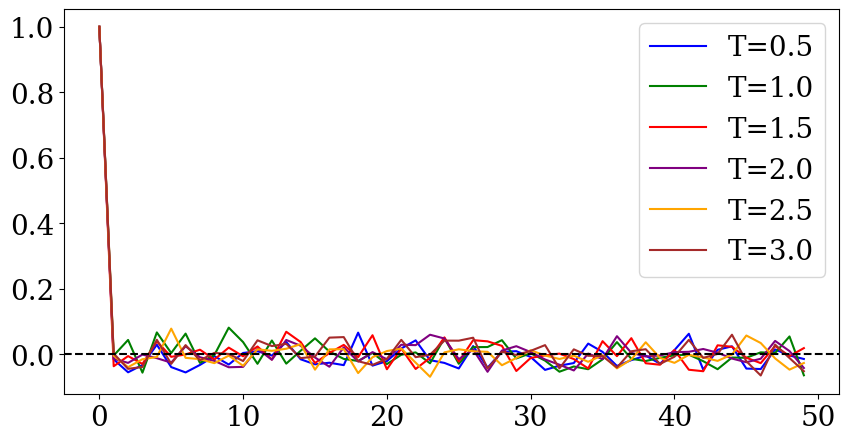

In [8]:
### Magnetization autocorrelation
from utils.gen_utils import autocorr
plt.figure(figsize=(10,5))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

betas = [0.3,0.35, 0.4, 0.45,0.5,0.6,0.8]
init_style = "random"
# energy autocorrelation
for i, temp in enumerate(temps):
    corr = autocorr(results_mcmc[(temp, init_style)][1])
    corr = corr[:50]
    plt.plot(corr, color=colors[i], label=f'T={temp}')

# draw horizontal line at 0.0
plt.axhline(y=0.0, color='black', linestyle='--')
plt.legend()
plt.show()

In [15]:
tmax = 150
temps = np.linspace(0.01, 2.0, 200)
n_sample_interval = 1 # look at autocorrelation
n_equilib_steps = 100 # look at thermalization
n_mcmc_steps = 100 # gives us 200 samples
n_samples = None 

tmax = 100
sim = MamSimulation(tmax=tmax)
coordinates, evolve, G = sim.simulate()
nodes, neighbors = graph_to_model_format(G)

from main_tree import simulate_ising_full

magn, energy, specific_heat, susceptibility = [], [], [], []

# models = simulate_ising_full(nodes, neighbors, J, n_equilib_steps, n_mcmc_steps, n_samples, n_sample_interval, temps)

# for t in temps:
#     magn.append(models[t].avg_magn)
#     energy.append(models[t].avg_energy)
#     specific_heat.append(models[t].specific_heat)
#     susceptibility.append(models[t].susceptibility)

for T in temps:
    nodes = np.random.choice([-1, 1], size=nodes.size)
    model = IsingModel(
        nodes=nodes,
        neighbors=neighbors,
        temp=T,
        J=1.0,
        n_equilib_steps=n_equilib_steps,
        n_mcmc_steps=n_mcmc_steps,
        n_samples=n_samples,
        n_sample_interval=n_sample_interval,
        step_algorithm=step_algorithm
    )
    model = simulate_ising_model(model)
    magn.append(model.avg_magn)
    energy.append(model.avg_energy)
    specific_heat.append(model.specific_heat)
    susceptibility.append(model.susceptibility)

Starting simulation...


100%|██████████| 100/100 [00:00<00:00, 976.29it/s]

Branch growth simulation completed in 0.10445308685302734 seconds


Temperature: 0.01 - Time taken: 54.412765979766846
Temperature: 0.02 - Time taken: 53.12552189826965
Temperature: 0.03 - Time taken: 53.57128715515137
Temperature: 0.04 - Time taken: 53.873178005218506
Temperature: 0.05 - Time taken: 54.72807312011719
Temperature: 0.060000000000000005 - Time taken: 53.75837731361389
Temperature: 0.06999999999999999 - Time taken: 53.71531009674072
Temperature: 0.08 - Time taken: 54.72134280204773
Temperature: 0.09 - Time taken: 54.09193706512451
Temperature: 0.09999999999999999 - Time taken: 54.50152611732483
Temperature: 0.11 - Time taken: 52.75016808509827
Temperature: 0.12 - Time taken: 52.55061626434326
Temperature: 0.13 - Time taken: 53.05536484718323
Temperature: 0.14 - Time taken: 52.829225301742554
Temperature: 0.15000000000000002 - Time taken: 52.69142007827759
Temperature: 0.16 - Time taken: 52.47432994842529
Temperature: 0.17 - Time taken: 52.46654486656189
Temperature: 0.18000000000000002 - Time taken: 52.71836066246033
Temperature: 0.19 - T

In [16]:
tmax

100

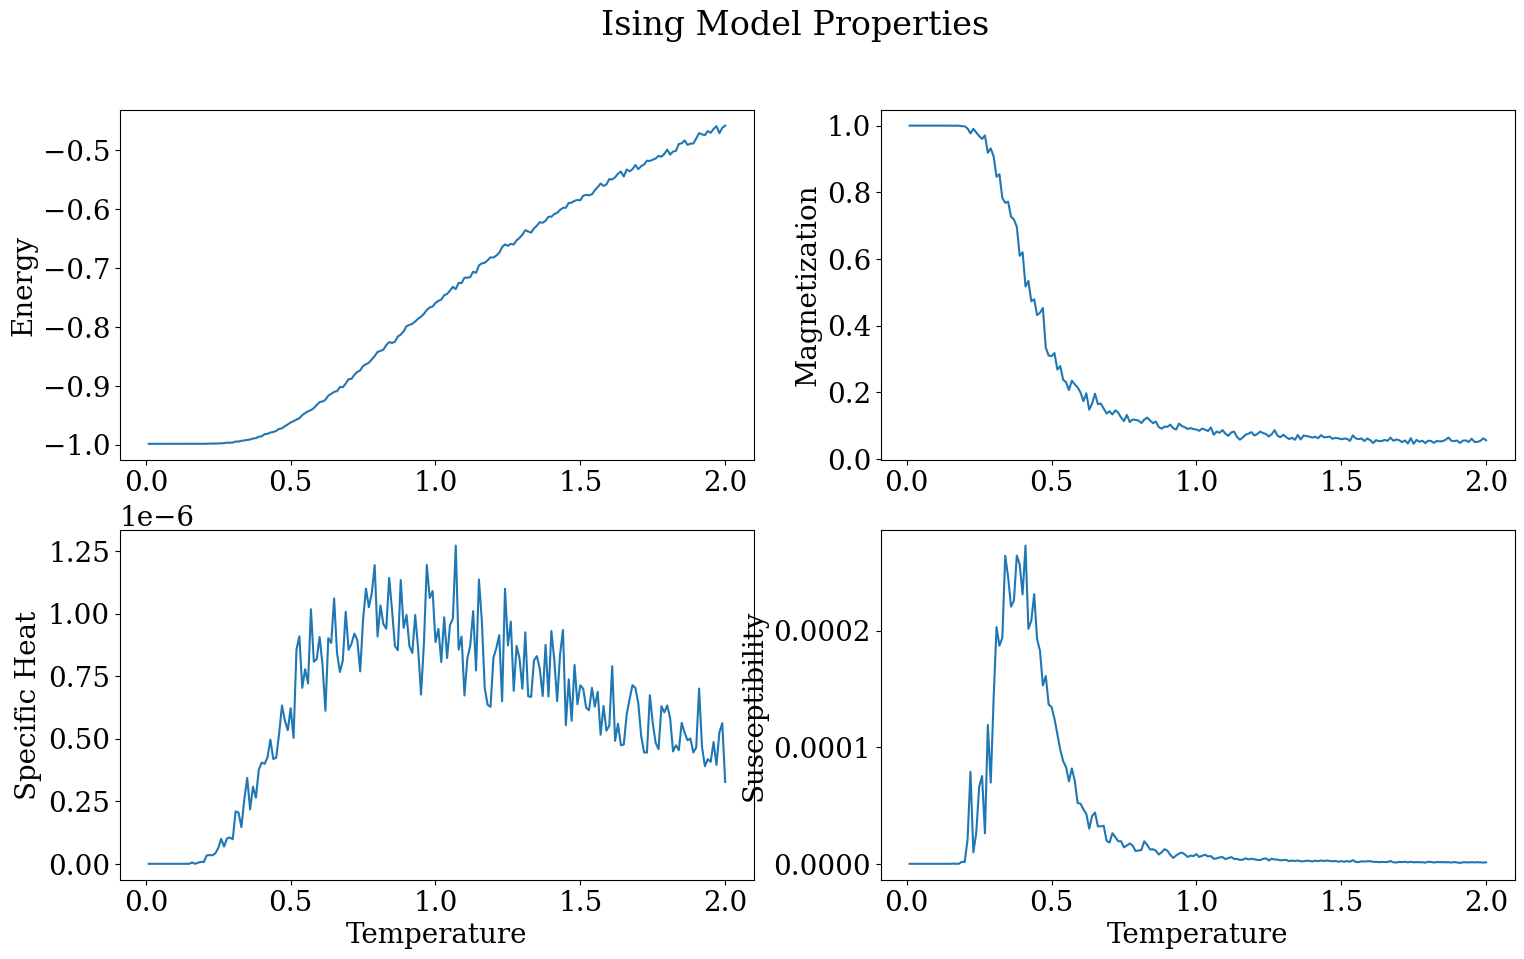

In [17]:
from utils.gen_utils import plot_magn_energy_spech_susc
plot_magn_energy_spech_susc(
    magn=magn,
    energy=energy,
    specific_heat=specific_heat,
    susceptibility=susceptibility,
    temps=temps,
    show=True
)